# Main Thesis Topic: “Zero-shot classification of ECG signals using CLIP-like model”.

**For example: Train on PBT-XL:**

- Text Encoder: ClinicalBERT (trained on diagnoses of ECG signal to obtain corresponding embeddings)
- Image Encoder: 1D-CNN (used to encode ECG signal to obtain signal embeddings)

- Experiment A): Baseline: We can take only the name of the class. For example, take “Myocardial Infarction” as a text. We should exclude some classes from training and after training is completed, the CLIP-like model can be tested on these excluded classes.
    - Next, we get embeddings of text from ClinicalBERT and train the ECG encoder with contrastive loss.

- Experiment B): Same as Experiment A but instead of testing on the same dataset/classes, we would test on other datasets containing different classes.

**Evaluation metrics:**
- Main: AUC-ROC, average_precison_score,
- Optional: Specificity, Sensitivity, F1-score

**Outcome:**
- It’s possible to train CLIP-like models with freezed (or unchanged/not fine tuned for downstream tasks) text encoder
- Training ECG encoders that are viable for representing different domains (within ECG modality) and previously unseen classes.
- Training a CLIP-like model on ECGs has little novelty.

First, we preprocess the ECG data from the PhysioNet 2021 challenge dataset. This data will be loaded using the ```PhysioNetDataset``` class.

In [ ]:
pip install transformers

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import random
from tqdm import tqdm
from scipy.signal import resample
import torch
from transformers import AutoTokenizer, AutoModel
import ast
import scipy.io as sio
from torch.utils.data import random_split
from torch.nn.functional import cosine_similarity
from scipy import signal

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PyFiles_PATH = '/content/drive/MyDrive/ECG Project (Shared Folder)/PyFiles'
PyFiles_PATH

'/content/drive/MyDrive/ECG Project (Shared Folder)/PyFiles'

In [ ]:
sys.path.append(PyFiles_PATH)

In [ ]:
# Path to training folder within PhysioNet dataset
PhysioNet_PATH = '/content/drive/MyDrive/ECG Project (Shared Folder)/Datasets/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'/content/drive/MyDrive/ECG Project (Shared Folder)/Datasets/physionet.org/files/challenge-2021/1.0.3/training'

Using the ```PhysioNet_PATH```, we can create separate datasets for training, testing & validation.

# Stage 1: Data Preprocessing

- train_set (train & validation data)
- test_set (test data)

First, let's load the SNOWMED-CT mappings. These mappings will be used in the `PhysioNetDataset` class to return the `TextEncoder` embeddings of the diagnosis of the corresponding ECG signal based on the code found in the ECG signal's header (.hea) file.

In [ ]:
smowmed_mappings_path = '/content/drive/MyDrive/ECG Project (Shared Folder)/Data/SNOWMED-CT Codes/combined_mappings.csv'

# Load the SNOMED-CT mappings
smowmed_mappings = pd.read_csv(smowmed_mappings_path)
smowmed_mappings.head(2)

,Dx,SNOMEDCTCode,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes
0,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,1780,0,5255,NaN
1,atrial flutter,164890007,AFL,0,54,0,1,73,186,445,7615,8374,NaN


In [ ]:
# Select the 'Dx' and 'SNOMEDCTCode' columns
codes = smowmed_mappings[['Dx', 'SNOMEDCTCode']]

# Set 'SNOWMEDCTCode' as the index
codes.set_index('SNOMEDCTCode', inplace=True)

# Convert the DataFrame into a dictionary
codes_dict = codes['Dx'].to_dict()

In [ ]:
list(codes_dict.items())[:5]

[(164889003, 'atrial fibrillation'),
 (164890007, 'atrial flutter'),
 (6374002, 'bundle branch block'),
 (426627000, 'bradycardia'),
 (733534002, 'complete left bundle branch block')]

In [ ]:
class PhysioNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=False):
        self.dataset_path = dataset_path
        self.dataset_path = [path for path in self.dataset_path if "index.html" not in path]
        self.train = train
        self.file_list = os.listdir(dataset_path)
        self._hea_files = []
        self._mat_files = []
        self._indices_files = []
        self._hea_files_path = []
        self._mat_files_path = []

        self.file_PATHS = []  # Directory to main database folders
        self.data_files = []  # Directory to data files

        # Validation Case: PTB Databases only
        if self.train == False:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        # Training Case: All Databases excluding PTB
        else:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file not in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        for path in self.file_PATHS:
            if os.path.isdir(path):
                for sub_folder in os.listdir(path):
                    sub_folder_path = os.path.join(path, sub_folder)
                    sub_folder_path = sub_folder_path.replace('\\', '/')

                    # Ignore index.html files
                    if sub_folder_path.endswith('index.html'):
                        self._indices_files.append(sub_folder_path)
                    else:
                        if os.path.isdir(sub_folder_path):
                            for file in os.listdir(sub_folder_path):
                                # Get all .hea files
                                if file.endswith('.hea'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._hea_files.append(file_path)
                                    self._hea_files_path.append(file_path)
                                # Get all .mat files
                                elif file.endswith('.mat'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._mat_files.append(file_path)
                                    self._mat_files_path.append(file_path)

    def resample_ecg(self, ecg, new_length=1280):
        # Get the current length of the ECG
        current_length = ecg.shape[1]

        # Resample the ECG
        resampled_ecg = resample(ecg, new_length, axis=1)

        return resampled_ecg

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        # 1. Get .hea file
        hea_file_path = self._hea_files[index]
        with open(hea_file_path, 'r') as f:
            lines = f.readlines()

        dx_modalities = None
        # Parse header information
        for line in lines:
            if line.startswith('# Dx:'):
                dx_codes = line.split(':')[1].strip().split(',')
                dx_modalities = [codes_dict.get(int(code.strip()), code.strip()) for code in dx_codes]

        # 2. Get .mat file
        twelve_lead_ecg = None
        if index < len(self._mat_files):
            mat_file_path = self._mat_files[index]
            mat_data = sio.loadmat(mat_file_path)

            # Extract the ECG data
            twelve_lead_ecg = mat_data['val']

            # Resample the ECG if it is not None
            twelve_lead_ecg = self.resample_ecg(twelve_lead_ecg)

        else:
            print(f"MAT file for index {index} does not exist.")

        # Return list of diagnoses and the np array of the 12-lead ECG
        return dx_modalities, twelve_lead_ecg


    def plot_record(self, index):
        mat_file_path = self._mat_files[index]
        data = sio.loadmat(mat_file_path)
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

        for i, ax in enumerate(axs.flat):
            ax.plot(data['val'][i], linewidth=0.5)
            ax.set_xlabel('Sample')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Lead {i+1}')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self._hea_files)

In [ ]:
train_set = PhysioNetDataset(PhysioNet_PATH, train=True)
test_set = PhysioNetDataset(PhysioNet_PATH, train=False)
len(train_set), len(test_set)

(66167, 22352)

The ```train_set``` can be split into ```current_train``` (85%) and ```current_val``` (15%).

In [ ]:
# Set the seed for the random number generator
torch.manual_seed(0)

# Get the length of the train_set
length = len(train_set)

# Calculate the lengths of the splits
train_length = int(0.85 * length)
val_length = length - train_length

# Split the dataset
current_train, current_val = random_split(train_set, [train_length, val_length])

In [ ]:
len(current_train), len(current_val)

(56241, 9926)

In [ ]:
# Diagnoses
current_train[0][0]

['atrial fibrillation', 't wave abnormal']

In [ ]:
# 12-lead ECG (np array)
current_train[0][1]

array([[  -53.0193656 ,  -153.73698541,  -131.75928891, ...,
           39.40560288,    21.86975076,    55.72637571],
       [  174.78383276,    96.49488033,    34.93601968, ...,
           95.66265945,   111.81362975,   151.18123563],
       [  227.72410522,   249.46919432,   166.43724399, ...,
           55.67239832,    89.47215286,    95.34224237],
       ...,
       [-1149.97464566, -1929.26407749, -1368.5743241 , ...,
          208.76267505,    43.36555469,   357.01820863],
       [ -231.49345112,  -369.58315849,  -130.28722674, ...,
           32.88990814,    -5.29595928,    96.96680224],
       [ -242.1306657 ,  -482.70634239,  -380.16644994, ...,
           64.53339128,    14.34194202,    87.73438775]])

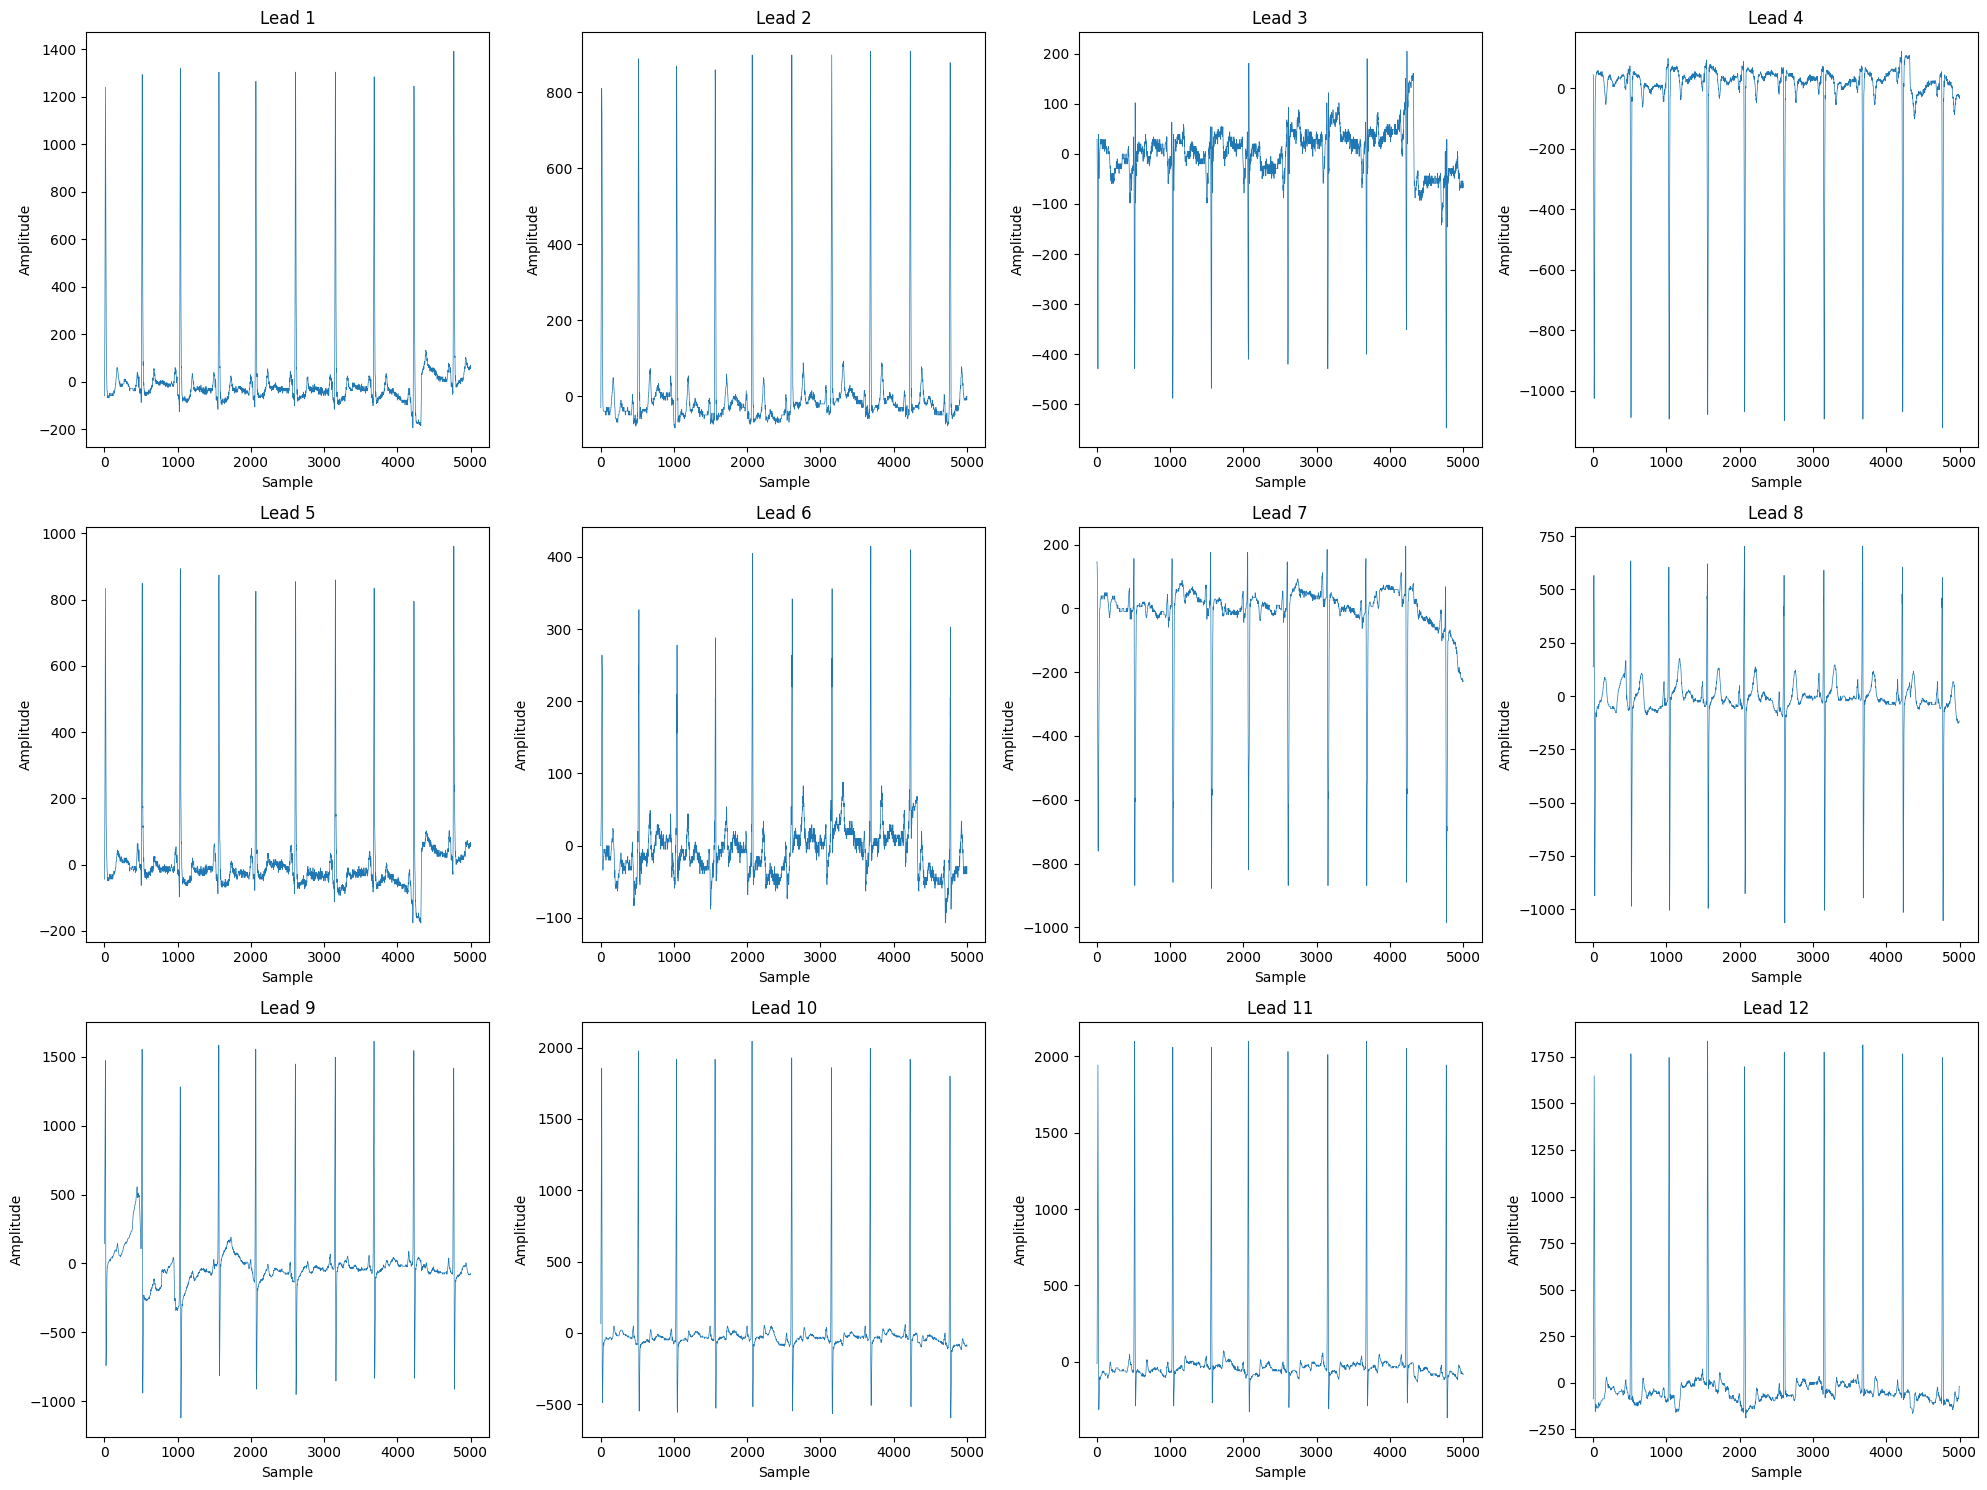

In [ ]:
current_train.dataset.plot_record(0)

# Stage 2: ECG Classification Model Pipeline

Now that our data is preprocessed, we can begin working on the Model Pipeline itself. The ECG Classification Model Pipeline will consist of three components:

1. `TextEncoder()` class

2. `ECGEncoder()` class

3. `InstanceSelector()` class

4. `CLIPModel()` class

An overview and outline of each of these components can be found below in their respective subsections.

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## TextEncoder()

Create a class, ```TextEncoder()``` that is used to convert the description of the (dx_modality) diagnosis class into an embeddings using the pretrained, base ClinicalBERT model.

- Input should be a concatenated using comma or blank space string of diagnoses/dx_modality per ECG signal.
- Use processed CSV files (dx_modality only)
- Frozen weights (since it's already pretrained)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(self.device)

        # Add embed_dim attribute
        self.embed_dim = self.model.config.hidden_size


    def encode(self, text_list):
        # Check if text_list is a string representation of a list
        if isinstance(text_list, str):
            text_list = ast.literal_eval(text_list)
        # Convert list of strings to a single string
        text = ', '.join(text_list)
        # Tokenize text
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # Move inputs to the correct device
        inputs = {name: tensor.to(self.device) for name, tensor in inputs.items()}
        # Get embeddings from ClinicalBERT model
        with torch.no_grad():
            embeddings = self.model(**inputs).last_hidden_state
        # Average the embeddings to get single vector per each input
        embeddings = torch.mean(embeddings, dim=1)
        return embeddings.to(self.device)

In [ ]:
text_encoder = TextEncoder(device).to(device)
# Example
embeddings = text_encoder.encode(current_train[0][0])

In [ ]:
print(embeddings.size())
print(type(embeddings))

torch.Size([1, 768])
<class 'torch.Tensor'>


## ECGEncoder()

- Input is ECG signal, output will be embeddings of ECG signal
- This is going to be model in model.py
- Model weights are updated iteratively
- optimizer = torch.optim.Adam(clip_model.ECGEncoder.parameters())

In [ ]:
class ECGEncoder(nn.Module):
    def __init__(self):
        super(ECGEncoder, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 5
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 6
        self.conv6 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU()
        self.pool6 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 7
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm1d(512)
        self.relu7 = nn.ReLU()
        self.pool7 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 8
        self.conv8 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm1d(512)
        self.relu8 = nn.ReLU()
        self.pool8 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 9
        self.conv9 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn9 = nn.BatchNorm1d(512)
        self.relu9 = nn.ReLU()
        self.pool9 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Layer 10
        self.conv10 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm1d(512)
        self.relu10 = nn.ReLU()
        self.pool10 = nn.AvgPool1d(kernel_size=2, stride=2)

        # Fully Connected Layer 1
        # self.fc1 = nn.Linear(512*4, 768)
        self.relu11 = nn.ReLU()

        # Add embed_dim attribute
        self.embed_dim = 768

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Layer 6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        # Layer 7
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.pool7(x)

        # Layer 8
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)

        # Layer 9
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        x = self.pool9(x)

        # Layer 10
        x = self.conv10(x)
        x = self.bn10(x)
        x = self.relu10(x)
        x = self.pool10(x)

        # Flatten the output of the convolutional layers
        print(x.size())
        x = x.view(x.size(0), -1)

        # Initialize self.fc1 here, using the size of x
        if not hasattr(self, 'fc1'):
            self.fc1 = nn.Linear(x.size(1), self.embed_dim).to(x.device)
        x = self.fc1(x)
        x = self.relu11(x)

        return x

In [ ]:
# Instantiate the model
model = ECGEncoder()

# Convert the numpy array to a PyTorch tensor
input_data = torch.from_numpy(current_train[0][1]).float()

# Add an extra dimension to the tensor to represent the batch size
input_data = input_data.unsqueeze(0)

# Pass the tensor through the model
output = model(input_data)

# Print the output
print(output)

torch.Size([1, 512, 1])
tensor([[0.0619, 0.0000, 0.2072, 0.0000, 0.0000, 0.6275, 0.0000, 0.0000, 0.3148,
         0.0000, 0.1820, 0.5330, 0.4248, 0.0000, 0.1726, 0.2214, 0.0000, 0.0000,
         0.2401, 0.0000, 0.0000, 0.0000, 0.3614, 0.0017, 0.0000, 0.0000, 0.0000,
         0.0637, 0.0000, 0.6041, 0.0000, 0.0000, 0.0193, 0.0000, 0.2076, 0.1255,
         0.0621, 0.0000, 0.2248, 0.0000, 0.0000, 0.0000, 0.0000, 0.6337, 0.0000,
         0.2130, 0.0000, 0.0000, 0.0000, 0.4857, 0.0000, 0.1216, 0.0000, 0.4678,
         0.0525, 0.0000, 0.4836, 0.0243, 0.0000, 0.0000, 0.0294, 0.0970, 0.0000,
         0.1720, 0.3926, 0.6508, 0.0000, 0.0000, 0.0000, 0.4275, 0.0000, 0.0000,
         0.1944, 0.0000, 0.0000, 0.0000, 0.0614, 0.3396, 0.1702, 0.1674, 0.1980,
         0.0000, 0.0000, 0.1977, 0.0000, 0.0000, 0.1109, 0.0372, 0.0722, 0.0250,
         0.0840, 0.0000, 0.0000, 0.1517, 0.0000, 0.1668, 0.0000, 0.0990, 0.0086,
         0.0000, 0.0000, 0.3803, 0.0000, 0.1015, 0.1524, 0.0000, 0.3200, 0.2152,
    

In [ ]:
# Count the parameters
num_params = count_parameters(model)
print(f'The ECGEncoder model has {num_params} trainable parameters.')

The model has 4073232 trainable parameters


In [ ]:
# Set the model to evaluation mode
model.eval()

# Pass the data through the model
output = model(input_data)

print(type(output))

torch.Size([1, 512, 1])
<class 'torch.Tensor'>


## CLIPModel

The final component of the Model Pipeline is to create a `ClIPModel` class which takes `TextEncoder` and `ECGEncoder` to train the final model with contrastive loss.

```
# image_encoder - ResNet or Vision Transformer
# text_encoder - CBOW or Text Transformer
# I[n, h, w, c] - minibatch of aligned images
# T[n, l] - minibatch of aligned texts
# W_i[d_i, d_e] - learned proj of image to embed
# W_t[d_t, d_e] - learned proj of text to embed
# t - learned temperature parameter
# extract feature representations of each modality
I_f = image_encoder(I) #[n, d_i]
T_f = text_encoder(T) #[n, d_t]
# joint multimodal embedding [n, d_e]
I_e = l2_normalize(np.dot(I_f, W_i), axis=1)
T_e = l2_normalize(np.dot(T_f, W_t), axis=1)
# scaled pairwise cosine similarities [n, n]
logits = np.dot(I_e, T_e.T) * np.exp(t)
# symmetric loss function
labels = np.arange(n)
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
Figure 3. Numpy-like pseudocode for the core of an implementation of CLIP
```

In [ ]:
class CLIPModel(nn.Module):
    def __init__(self, text_encoder, ecg_encoder, embed_dim, temperature):
        super(CLIPModel, self).__init__()
        self.text_encoder = text_encoder
        self.ecg_encoder = ecg_encoder
        self.temperature = temperature
        self.W_i = nn.Linear(ecg_encoder.embed_dim, embed_dim)
        self.W_t = nn.Linear(text_encoder.embed_dim, embed_dim)

    def forward(self, ecgs, texts):
        # Extract feature representations of each modality
        I_f = self.ecg_encoder(ecgs)  # [n, d_i]
        T_f = torch.stack([self.text_encoder.encode(text).squeeze() for text in texts])  # [n, d_t]

        # Joint multimodal embedding [n, d_e]
        I_e = F.normalize(self.W_i(I_f), dim=1)
        T_e = F.normalize(self.W_t(T_f), dim=1)

        # print(f"I_e shape: {I_e.shape}")
        # print(f"T_e shape: {T_e.shape}")

        # Scaled pairwise cosine similarities [n, n]
        logits = torch.matmul(I_e, T_e.t()) / self.temperature

        # Symmetric loss function
        labels = torch.arange(len(ecgs)).to(ecgs.device)
        loss_i = F.cross_entropy(logits, labels)
        loss_t = F.cross_entropy(logits.t(), labels)
        loss = (loss_i + loss_t) / 2

        return loss

# DataLoaders

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

In [ ]:
# Instantiate the encoders
text_encoder = TextEncoder(device).to(torch.device("cuda"))
ecg_encoder = ECGEncoder().to(torch.device("cuda"))

# Instantiate the encoders and the model
CLIP_model = CLIPModel(text_encoder, ecg_encoder, embed_dim=512, temperature=1)

In [ ]:
# Parameters
lr = 0.001
weight_decay = 0.01
optimizer = torch.optim.Adam(CLIP_model.parameters(), lr=lr, weight_decay=weight_decay)
num_epochs = 3

## Model training - current_train dataset

In [ ]:
current_train_loader = DataLoader(current_train, batch_size=64, collate_fn=collate_fn)

In [ ]:
def train_model(model, optimizer, num_epochs, device):
    # Move model to the device
    CLIP_model.to(device)

    # Store the losses for each epoch
    losses = []

    for epoch in range(num_epochs):
        CLIP_model.train()  # Set the model to training mode
        running_loss = 0.0
        pbar = tqdm(enumerate(current_train_loader, 0), total=len(current_train_loader), leave=False)

        for i, data in pbar:
            # Extract the samples
            texts = data[0]  # Move texts to the device
            ecgs = data[1].float().to(device)  # ecgs is already a tensor, just move it to the device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Pass the tensor and texts through the model
            loss = CLIP_model(ecgs, texts)  # Pass the tensor directly

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1} Loss: {running_loss/(i+1):.4f}")
        epoch_loss = running_loss / len(current_train)
        losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

    return CLIP_model, losses

In [ ]:
train_model(CLIP_model, optimizer, num_epochs, device)

  0%|          | 0/879 [00:00<?, ?it/s]

torch.Size([64, 512, 1])
I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])


Epoch 1 Loss: 4.1602:   0%|          | 1/879 [00:01<26:44,  1.83s/it]

torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1591:   0%|          | 2/879 [01:49<15:39:37, 64.28s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1590:   0%|          | 3/879 [03:36<20:21:26, 83.66s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1592:   0%|          | 4/879 [05:22<22:29:49, 92.56s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1590:   1%|          | 5/879 [07:10<23:50:24, 98.20s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1574:   1%|          | 6/879 [08:57<24:29:53, 101.02s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1580:   1%|          | 7/879 [10:45<25:01:45, 103.33s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1571:   1%|          | 8/879 [12:34<25:25:48, 105.11s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1537:   1%|          | 9/879 [14:21<25:32:20, 105.68s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])
torch.Size([64, 512, 1])


Epoch 1 Loss: 4.1506:   1%|          | 10/879 [16:07<25:32:29, 105.81s/it]

I_e shape: torch.Size([64, 512])
T_e shape: torch.Size([64, 512])


KeyboardInterrupt: ignored

In [ ]:
for i, (input_ids, labels) in enumerate(current_train):
    print(f"Medical conditions: {input_ids}, Length: {len(input_ids)}, Labels Length: {len(labels)}")
    if i > 10:  # print for first 10 samples
        break